# Тестове завдання на позицію Data scіentist Junior (PrivatBank)

## Завдання:
Маємо файл з даними 'train_df.csv'.
Поля:
id - ідентифікатор об'єкта,
gb - target

Поля, що починаються на "cat_" - категоріальні
Поля, що починаються на "num_" – числові.

Суть завдання – побудувати модель бінарної класифікації на Python.

## Імпортуємо потрібні бібліотеки 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Зчитуємо та оглядаємо дані

In [2]:
df = pd.read_csv('train_df.csv', header = 0, sep = '\t', index_col = 0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26824 entries, 0 to 61111
Columns: 553 entries, num_1 to gb
dtypes: float64(416), int64(137)
memory usage: 113.4 MB


In [4]:
df.head()

,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,num_8,num_9,...,num_413,cat_132,cat_133,num_414,num_415,num_416,cat_134,cat_135,id,gb
0,1377.3,3712.9,NaN,1303.0,2409.0,1281.7,43.0,1,195.0,NaN,...,11327.5,1,1,28162496.65,0.0,0.07,1,1,1,0
1,20.0,13.4,NaN,565.0,NaN,357.2,19.0,1,170.0,NaN,...,168.6,1,1,989383.82,0.0,0.56,2,1,2,0
4,150.6,1.8,NaN,2294.0,15.0,107.6,76.0,1,196.0,2.3,...,209.1,1,1,87444.51,0.0,0.01,3,1,3,0
5,11.4,178.0,NaN,1236.0,NaN,350.6,41.0,1,117.0,5.3,...,56.9,1,1,297608.00,0.0,0.08,4,1,4,0
6,5372.0,3386.0,NaN,1340.0,NaN,14.0,45.0,1,9.0,108.0,...,31.0,1,1,6614247.89,0.0,0.20,1,1,5,0


### Подвимося на пропуски

In [5]:
nan_values = pd.DataFrame(df.isna().sum()).sort_values(by = 0, ascending=False)

In [6]:
count_of_nan = nan_values[nan_values[0] >= df.shape[0]*0.3].count()[0]
print(f"Дані мають {count_of_nan} колонок, в яких пропущено 30% або більше значень, видалимо проблемні колонки.")
df_without_nan = df.dropna(axis = 1, thresh=df.shape[0]*0.7, inplace = False)
print(f"Після видалення, кількість атрибутів = {df_without_nan.shape[1]}")

Дані мають 172 колонок, в яких пропущено 30% або більше значень, видалимо проблемні колонки.
Після видалення, кількість атрибутів = 381


In [7]:
df_without_nan.head()


,num_1,num_2,num_4,num_6,num_7,cat_1,num_8,num_10,num_13,num_14,...,num_413,cat_132,cat_133,num_414,num_415,num_416,cat_134,cat_135,id,gb
0,1377.3,3712.9,1303.0,1281.7,43.0,1,195.0,27.4,2210.0,12970.8,...,11327.5,1,1,28162496.65,0.0,0.07,1,1,1,0
1,20.0,13.4,565.0,357.2,19.0,1,170.0,NaN,68.0,123.6,...,168.6,1,1,989383.82,0.0,0.56,2,1,2,0
4,150.6,1.8,2294.0,107.6,76.0,1,196.0,5.3,33.0,71.6,...,209.1,1,1,87444.51,0.0,0.01,3,1,3,0
5,11.4,178.0,1236.0,350.6,41.0,1,117.0,25.2,39.0,57.6,...,56.9,1,1,297608.00,0.0,0.08,4,1,4,0
6,5372.0,3386.0,1340.0,14.0,45.0,1,9.0,716.0,401.0,2447.0,...,31.0,1,1,6614247.89,0.0,0.20,1,1,5,0


##### Пропуски, які залишилися, заповнимо пізніше

### Перевіримо кореляцію

Визначимо, чи маємо колонки кореляція між якими є досить вискокою (0.9 по модулю). Якщо кореляція між двома змінними буде більше, ніж 0.9, то ми маємо справу з атрибутами, які можуть замінити один одного. Тож, при знаходженні такої поведінки, видалимо одну з колонок, так як вона пояснюється іншою.

Створимо матрицю кореляцій, виключемо з неї головну діагональ та нижній трикутник (так як вона симетрична, а на діагоналі присутні кореляції колонок самих з собою).

Колонки, кореляція яких більше 0.9 по модулю видаляємо.

In [8]:
corr_matrix = df_without_nan.corr().abs()
up_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
corr_to_drop = [column for column in up_triangle.columns if any(up_triangle[column] > 0.9)]
print("Колонки, які необхідно видалити")
print(corr_to_drop)

Колонки, які необхідно видалити
['num_7', 'num_33', 'cat_13', 'num_62', 'num_64', 'num_69', 'num_71', 'num_75', 'num_80', 'num_81', 'num_83', 'num_84', 'cat_29', 'cat_30', 'num_92', 'num_97', 'num_107', 'num_111', 'num_113', 'num_114', 'num_117', 'num_119', 'num_124', 'num_128', 'num_134', 'cat_42', 'num_136', 'num_137', 'num_144', 'num_148', 'cat_53', 'num_155', 'num_168', 'num_172', 'num_173', 'num_175', 'num_181', 'num_186', 'num_187', 'num_193', 'num_194', 'num_196', 'cat_62', 'cat_66', 'num_206', 'cat_70', 'num_211', 'num_212', 'num_214', 'num_218', 'num_228', 'num_232', 'num_234', 'num_235', 'num_237', 'num_238', 'num_239', 'cat_79', 'num_244', 'cat_86', 'cat_92', 'num_264', 'num_265', 'num_267', 'num_268', 'num_269', 'num_270', 'cat_93', 'num_275', 'cat_96', 'num_282', 'num_288', 'num_298', 'num_299', 'num_301', 'num_303', 'num_305', 'num_306', 'num_307', 'num_309', 'num_311', 'num_312', 'num_313', 'num_314', 'num_321', 'num_330', 'num_331', 'num_338', 'num_339', 'num_340', 'num

In [9]:
print(f"Кількість змінних, які мають досить високу кореляцію (0.9 по модулю) з іншими змінними - {len(corr_to_drop)}")

Кількість змінних, які мають досить високу кореляцію (0.9 по модулю) з іншими змінними - 123


In [10]:
df_res = pd.DataFrame(df_without_nan.drop(corr_to_drop, axis=1, inplace = False))
print(f"Результуючий Data Frame має {df_res.shape[1]} колонок") 


Результуючий Data Frame має 258 колонок


In [11]:
df_res.head()

,num_1,num_2,num_4,num_6,cat_1,num_8,num_10,num_13,num_14,num_15,...,num_408,num_413,cat_132,cat_133,num_415,num_416,cat_134,cat_135,id,gb
0,1377.3,3712.9,1303.0,1281.7,1,195.0,27.4,2210.0,12970.8,0.0,...,0.0,11327.5,1,1,0.0,0.07,1,1,1,0
1,20.0,13.4,565.0,357.2,1,170.0,NaN,68.0,123.6,2.0,...,0.0,168.6,1,1,0.0,0.56,2,1,2,0
4,150.6,1.8,2294.0,107.6,1,196.0,5.3,33.0,71.6,1.0,...,79.6,209.1,1,1,0.0,0.01,3,1,3,0
5,11.4,178.0,1236.0,350.6,1,117.0,25.2,39.0,57.6,2.0,...,0.0,56.9,1,1,0.0,0.08,4,1,4,0
6,5372.0,3386.0,1340.0,14.0,1,9.0,716.0,401.0,2447.0,0.0,...,0.0,31.0,1,1,0.0,0.20,1,1,5,0


### Побудуємо Pipeline

Спочатку виділимо окремо колонки з категоріальними та числовими даними, також видалимо колонку 'id'.


In [12]:
cat_columns = []
num_columns = []
for col in df_res.columns:
    if col[0:3] == 'cat':
        cat_columns.append(col)
    if col[0:3] == 'num':
        num_columns.append(col)
print(f"Колонки з категоріальними даними: {cat_columns}")
print(f"Колонки з числовими даними: {num_columns}")

Колонки з категоріальними даними: ['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11', 'cat_12', 'cat_14', 'cat_15', 'cat_16', 'cat_17', 'cat_18', 'cat_19', 'cat_20', 'cat_21', 'cat_22', 'cat_23', 'cat_24', 'cat_25', 'cat_26', 'cat_27', 'cat_28', 'cat_31', 'cat_32', 'cat_33', 'cat_34', 'cat_35', 'cat_36', 'cat_37', 'cat_38', 'cat_39', 'cat_40', 'cat_41', 'cat_43', 'cat_44', 'cat_45', 'cat_46', 'cat_47', 'cat_48', 'cat_49', 'cat_50', 'cat_51', 'cat_52', 'cat_54', 'cat_55', 'cat_56', 'cat_57', 'cat_58', 'cat_59', 'cat_60', 'cat_61', 'cat_63', 'cat_64', 'cat_65', 'cat_67', 'cat_68', 'cat_69', 'cat_71', 'cat_72', 'cat_73', 'cat_74', 'cat_75', 'cat_76', 'cat_77', 'cat_78', 'cat_80', 'cat_81', 'cat_82', 'cat_83', 'cat_84', 'cat_85', 'cat_87', 'cat_88', 'cat_89', 'cat_90', 'cat_91', 'cat_94', 'cat_95', 'cat_97', 'cat_98', 'cat_99', 'cat_100', 'cat_101', 'cat_102', 'cat_103', 'cat_104', 'cat_105', 'cat_106', 'cat_107', 'cat_108', 'cat_109', 'cat

In [13]:
df_res.drop('id', inplace = True, axis = 1)

Розділимо датасет на тренувальний та валідаційний.

In [14]:
X = df_res.drop('gb', inplace = False, axis = 1)
y = df_res['gb']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

Подивимося на цільову змінну

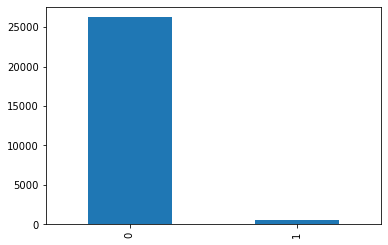

In [15]:
df_res['gb'].value_counts().plot(kind='bar')

Цільова змінна незбалансована, значення 0 переважає над 1

Побудуємо Pipeline.
Заповнимо пропущені значення та використаємо OneHotEncoding для категоріальних змінних.
Використаємо RandomForestClassifier та GridSearch

In [77]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns),
        ("cat", categorical_transformer, cat_columns),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

param_grid = {
    'classifier__n_estimators': [20,40,100],
    'classifier__max_depth': [8, 10, 16], 
    'classifier__random_state': [0],
    'classifier__class_weight': [{1:5}, {1:20}, {1:40}]
}

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)


Best params:
{'classifier__class_weight': {1: 40}, 'classifier__max_depth': 16, 'classifier__n_estimators': 100, 'classifier__random_state': 0}


Отримали параметри для нашої моделі, за допомогою GridSearchCV. А саме вагу(для відповідного класу (1), який має набагато меншу кількість значень) = 40, максимальну глибину дерева = 16, число дерев = 100

In [90]:
print(f"Значення для наших параметрів моделі: {grid_search.best_score_}")

Значення для наших параметрів моделі: 0.988722706425356


In [81]:
params = {'classifier__n_estimators': 100,
        'classifier__max_depth': 16, 
        'classifier__random_state': 0,
        'classifier__class_weight': {1:40}
         }
clf.set_params(**params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_1', 'num_2', 'num_4',
                                                   'num_6', 'num_8', 'num_10',
                                                   'num_13', 'num_14', 'num_15',
                                                   'num_19', 'num_26', 'num_27',
                                                   'num_28', 'num_29', 'num_30',
                                                   'num_32', 'num_38', 'num_40',
                                                   'num_41', 'num_43', 'num_45',
   

In [82]:
clf.fit(X_train, y_train)
print(f"Точність(accuracy) нашої моделі: {clf.score(X_valid, y_valid)}")

Точність(accuracy) нашої моделі: 0.9910531220876049


Ми отримали досить високу точність нашої моделі, але ми маємо незбалансовані класи, тому вимірювання точності для даної моделі не є досить доцільним. Скористаємося метрикою f1.

In [87]:
y_pred = clf.predict(X_valid)
print(f"f1: {f1_score(y_pred, y_valid)}")


f1: 0.7241379310344828


Побудуємо Confusion Matrix (матрицю суперечностей), щоб наглядно перевірити правильністі визначення класів.

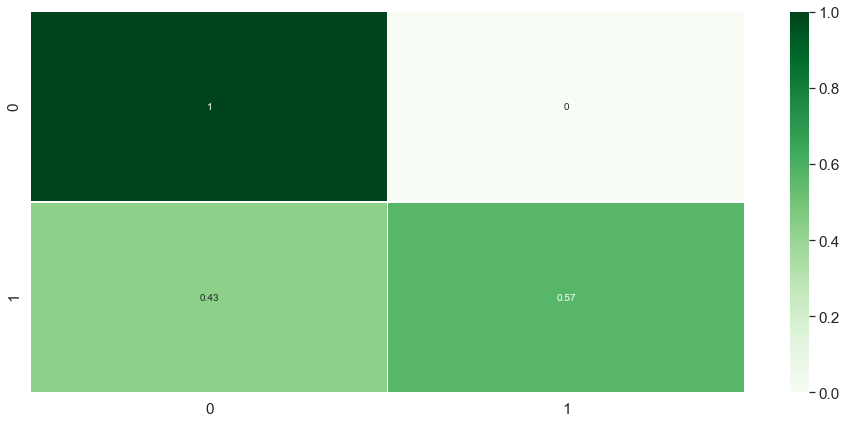

In [88]:
matrix = confusion_matrix(y_valid, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

Як результат ми отримали модель, яка з вірогідністю 100% передбачає клас 0 та з вірогідністю 57% передбачає клас 1. Отримані результати потребують доопрацювання(ваги для класу 1 скоріше за все повинні бути більшими, якщо звертату увагу в скількі разів клас 0 преважає клас 1), для якого потрібно більше інформації про самі дані, більше часу для підбору моделі та її параметрів, кращі потужності. Як альтернатива, можна було скористатися XGBoost, але підбор та побудова моделі забере досить велику кількість часу. Як я здогадуюся, датасет побудований на основі даних про підозрілі транзакції, ця задача завжди потребувала делікатного вирішення.